# Melanoma Detection using CNNs

## 1 Problem Statement
Melanoma is a type of skin cancer that can be deadly if not detected early and accounts for 75% of skin cancer deaths.

The goal of this deep learning project is to build a CNN based model which can evaluate images, accurately detect melanoma and alert dermatologists. Such a solution has the potential to reduce a lot of manual effort needed in diagnosis.

## 2 Project Pipeline
The project is executed as per the following steps:
- Data Reading/Data Understanding
- Dataset Creation
- Dataset Visualisation
- Model 1: Building & Training
- Data Augmentation
- Model 2: Building & Training with Data Augmentation
- Class Distribution
- Handling Class Imbalance
- Model 3: Building & Training on The Rectified Class Imbalance Data

## 3 Data Reading / Data Understanding

Reading the data and creating a dataset.

### Importing necessary libraries

In [1]:
import pathlib
import os
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Rescaling,Flatten,Dense

### Mounting and extracting data


In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#!unzip -q '/content/gdrive/MyDrive/CNN_assignment.zip'

In [4]:
# Defining paths for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


The dataset contains 2357 images of different skin cancer types. There are 9 sub-directories in each train and test subdirectory. The 9 sub-directories contain images of 9 skin cancer types.

### Creating a dataset
Loading images from the disk using the image_dataset_from_directory utility

In [6]:
# Importing libraries
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [7]:
# Defining some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [8]:
# Creating the train dataset using tf.keras.preprocessing.image_dataset_from_directory with seed=123 and image_size=(img_height,img_width)
train_ds = image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),seed=123,validation_split=0.2,subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Creating the validation dataset using tf.keras.preprocessing.image_dataset_from_directory with seed=123 and image_size=(img_height,img_width)
val_ds = image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),seed=123,validation_split=0.2,subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Listing all the classes of skin cancer and storing them in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 4 Data Visualisation
Visualising one instance of each of the nine classes present in the dataset

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

These image batches are unbatched for the purpose of visualising one instance of each class.

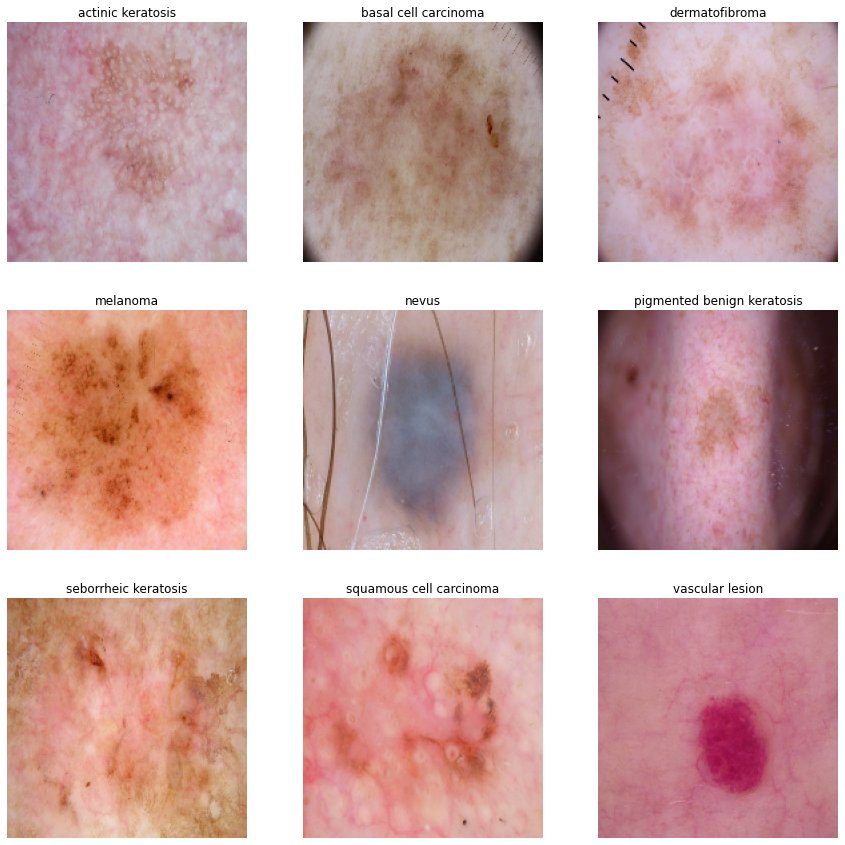

In [11]:
fig = plt.figure(figsize=(15,15))
unbatched_val_ds = val_ds.unbatch()
for i in range(len(class_names)):
  for image,label in unbatched_val_ds:
    if label==i:
      ax = fig.add_subplot(3,3,i+1)
      ax.imshow(image.numpy().astype('int'))
      ax.set_title(class_names[i])
      ax.axis('off')
      break

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 5 Model 1: Building & Training

### Creating the model
Creating a CNN model, which can accurately detect the 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range, which is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]` range.

In [13]:
model = Sequential()

model.add(Rescaling(1/255,input_shape=(img_height, img_width,3)))

model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(len(class_names),activation='softmax'))

### Compiling the model
Choosing an appropriate optimiser and loss function for model training 

In [14]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Viewing a summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dense (Dense)               (None, 32)                4147232   
                                                        

### Training the model

In [16]:
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 23s 78ms/step - loss: 2.1097 - accuracy: 0.2282 - val_loss: 1.8841 - val_accuracy: 0.3602
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.8337 - accuracy: 0.3281 - val_loss: 1.8246 - val_accuracy: 0.2841
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5702 - accuracy: 0.4554 - val_loss: 1.6728 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4636 - accuracy: 0.4994 - val_loss: 1.4866 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2905 - accuracy: 0.5564 - val_loss: 1.5435 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.1734 - accuracy: 0.5882 - val_loss: 1.5862 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.0559 - accuracy: 0.6417 - val_loss: 1.6500 - val_accuracy: 0.4966
Epoch 8/20
5

### Visualising the results

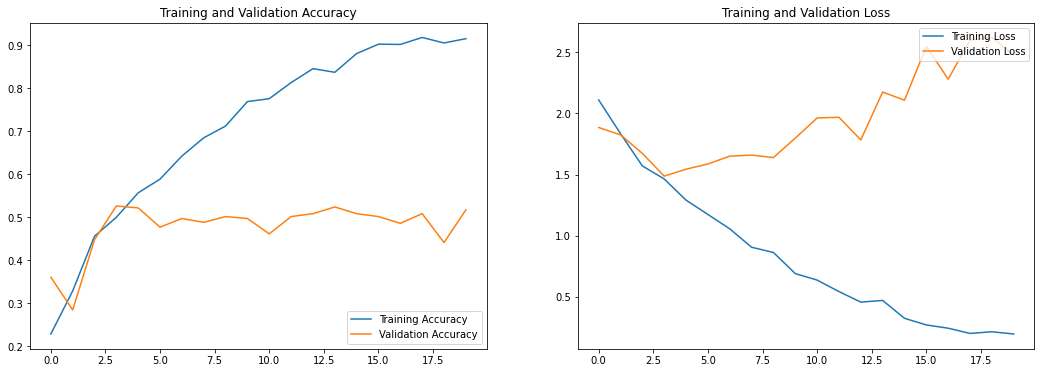

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(epochs_range, acc, label='Training Accuracy')
ax.plot(epochs_range, val_acc, label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_title('Training and Validation Accuracy')

ax = fig.add_subplot(1, 2, 2)
ax.plot(epochs_range, loss, label='Training Loss')
ax.plot(epochs_range, val_loss, label='Validation Loss')
ax.legend(loc='upper right')
ax.set_title('Training and Validation Loss')
fig.show()

After a number of epochs, the training accuracy keeps increasing while the validation accuracy flattens out. After 20 epochs, the training accuracy is much higher than the validation accuracy, which indicates overfitting.

## 6 Data Augmentation
Employing data augmentation and adding dropout layers (regularisation) to address overfitting

In [18]:
# Data augmentation is done with RandomFlip, RandomRotation and RandomContrast
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast

data_augmentation = Sequential([
                                RandomFlip("horizontal_and_vertical",seed=123),
                                RandomRotation(0.2,seed=123),
                                RandomContrast(0.2,seed=123)
])

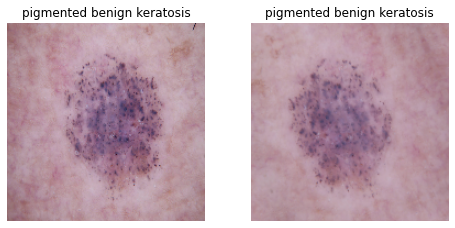

In [19]:
# Visualising the augmentation strategy for one instance of a training image
fig = plt.figure(figsize=(8,8))
for image,label in unbatched_val_ds.take(1):
  ax1 = fig.add_subplot(2,2,1)
  ax1.imshow(image.numpy().astype('int'))
  ax1.set_title(class_names[label])
  ax1.axis('off')

  ax2 = fig.add_subplot(2,2,2)
  ax2.imshow(data_augmentation(image).numpy().astype('int'))
  ax2.set_title(class_names[label])
  ax2.axis('off')
fig.show()

## 7 Model 2: Building & Training with Data Augmentation
Creating the model with a data augmentation layer and a dropout layer

In [20]:
from tensorflow.keras.layers import Dropout

In [21]:
model = Sequential()

model.add(Rescaling(1/255,input_shape=(img_height, img_width,3)))

model.add(data_augmentation)

model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.35,seed=123))

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(len(class_names),activation='softmax'))

### Compiling the model

In [22]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Viewing a summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (180, 180, 3)             0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                      

### Training the model

In [24]:
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20


56/56 [==============================] - ETA: 0s - loss: 2.4651 - accuracy: 0.2193

56/56 [==============================] - 11s 160ms/step - loss: 2.4651 - accuracy: 0.2193 - val_loss: 1.9436 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 9s 156ms/step - loss: 1.8385 - accuracy: 0.3214 - val_loss: 1.7217 - val_accuracy: 0.3870
Epoch 3/20
56/56 [==============================] - 9s 156ms/step - loss: 1.6537 - accuracy: 0.4169 - val_loss: 1.6409 - val_accuracy: 0.4049
Epoch 4/20
56/56 [==============================] - 9s 156ms/step - loss: 1.5959 - accuracy: 0.4247 - val_loss: 1.5283 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 9s 157ms/step - loss: 1.5196 - accuracy: 0.4671 - val_loss: 1.4592 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 9s 155ms/step - loss: 1.4685 - accuracy: 0.4816 - val_loss: 1.4462 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 9s 156ms/step - loss: 1.4517 - accuracy: 0.4855 - val_loss: 1.4470 - val_accuracy: 0.5056
Epoch 8/20
56/56

### Visualising the results

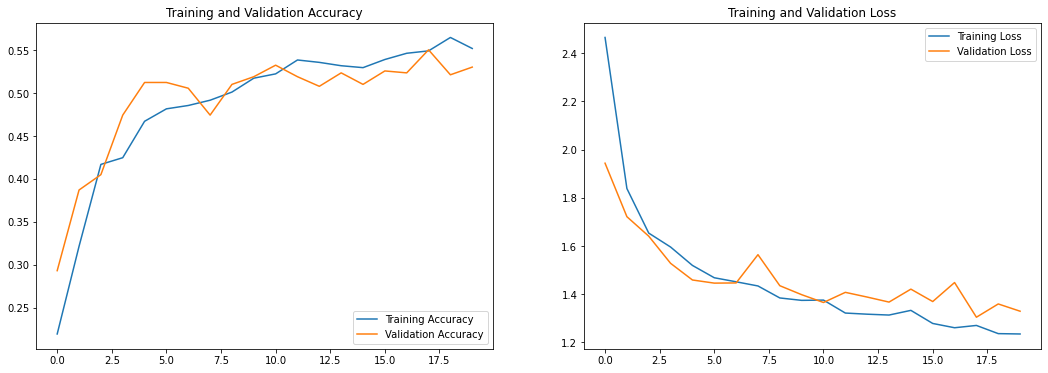

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(epochs_range, acc, label='Training Accuracy')
ax.plot(epochs_range, val_acc, label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_title('Training and Validation Accuracy')

ax = fig.add_subplot(1, 2, 2)
ax.plot(epochs_range, loss, label='Training Loss')
ax.plot(epochs_range, val_loss, label='Validation Loss')
ax.legend(loc='upper right')
ax.set_title('Training and Validation Loss')
fig.show()

The training and validation accuracies keep increasing with the number of epochs. After 20 epochs, the training accuracy and validation accuracy are comparable. Thus, the previous issue of overfitting is resolved and the current model is generalisable, but its accuracy is very low.

## 8 Class Distribution

Many a time, datasets can have class imbalance i.e. one class can have proportionately higher number of samples compared to others. Class imbalance can have a detrimental effect on the final model quality. Hence, as a sanity check, it is important to check the distribution of classes in the data.

In [26]:
# Finding the distribution of classes in the 'Train' directory
dist = [len(list((data_dir_train.joinpath(name)).glob('*.jpg'))) for name in class_names]
cls_dist = pd.DataFrame({'Class':class_names,'Count':dist})

In [27]:
cls_dist

,Class,Count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


**Findings**
- The class 'seborrheic keratosis' has the least number of samples.
- The classes 'melanoma' and 'pigmented benign keratosis' dominate in terms of proportionate number of samples.

## 9 Rectifying Class Imbalance

The Python package, `Augmentor` (https://augmentor.readthedocs.io/en/master/), is used to add more samples across all classes so that none of the classes has too few samples.

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


`Augmentor` is used as per the following procedure:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) +'/'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) # Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F433A1D7A60>: 100%|██████████| 500/500 [00:17<00:00, 28.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F43522D3640>: 100%|██████████| 500/500 [00:20<00:00, 24.91 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4352173E50>: 100%|██████████| 500/500 [00:15<00:00, 31.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F43B865C940>: 100%|██████████| 500/500 [01:24<00:00,  5.92 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F433A3E9400>: 100%|██████████| 500/500 [01:20<00:00,  6.20 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F43520F9C40>: 100%|██████████| 500/500 [00:15<00:00, 31.91 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F43521A7070>: 100%|██████████| 500/500 [00:39<00:00, 12.78 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F433A353B50>: 100%|██████████| 500/500 [00:15<00:00, 31.26 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F433A4AF340>: 100%|██████████| 500/500 [00:16<00:00, 31.17 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.

In [30]:
# Calculating the total count of augmented images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Viewing the distribution of augmented data after adding new images to the original training data

In [31]:
# Finding the distribution of classes in the training dataset
aug_dist = [len(list((data_dir_train.joinpath(name)).glob('*.jpg')))+len(list((data_dir_train.joinpath(name)).glob('output/*.jpg'))) for name in class_names]
aug_cls_dist = pd.DataFrame({'Class':class_names,'Count':aug_dist})

In [32]:
aug_cls_dist

,Class,Count
0,actinic keratosis,614
1,basal cell carcinoma,876
2,dermatofibroma,595
3,melanoma,938
4,nevus,857
5,pigmented benign keratosis,962
6,seborrheic keratosis,577
7,squamous cell carcinoma,681
8,vascular lesion,639


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## 10 Model 3: Building & Training on the Data Created Using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

### Creating a training dataset

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Creating a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating the model (with normalization)

In [36]:
model = Sequential()

model.add(Rescaling(1/255,input_shape=(img_height, img_width,3)))

model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.35,seed=123))

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(len(class_names),activation='softmax'))

### Compiling the model

In [37]:
# Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [38]:
epochs = 30
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/30
169/169 [==============================] - 32s 179ms/step - loss: 2.3432 - accuracy: 0.2285 - val_loss: 1.8130 - val_accuracy: 0.3148
Epoch 2/30
169/169 [==============================] - 26s 152ms/step - loss: 1.7024 - accuracy: 0.3477 - val_loss: 1.5527 - val_accuracy: 0.4529
Epoch 3/30
169/169 [==============================] - 26s 147ms/step - loss: 1.4514 - accuracy: 0.4609 - val_loss: 1.4451 - val_accuracy: 0.4647
Epoch 4/30
169/169 [==============================] - 25s 144ms/step - loss: 1.2011 - accuracy: 0.5694 - val_loss: 1.2921 - val_accuracy: 0.5612
Epoch 5/30
169/169 [==============================] - 25s 144ms/step - loss: 0.9454 - accuracy: 0.6664 - val_loss: 1.1390 - val_accuracy: 0.6102
Epoch 6/30
169/169 [==============================] - 25s 144ms/step - loss: 0.7422 - accuracy: 0.7454 - val_loss: 1.2129 - val_accuracy: 0.6251
Epoch 7/30
169/169 [==============================] - 25s 145ms/step - loss: 0.5338 - accuracy: 0.8218 - val_loss: 1.0875 - val_ac

### Visualising the results

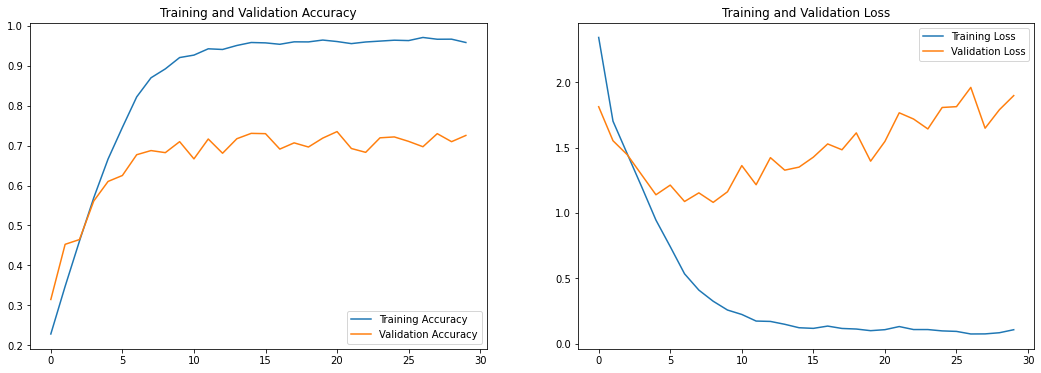

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(epochs_range, acc, label='Training Accuracy')
ax.plot(epochs_range, val_acc, label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_title('Training and Validation Accuracy')

ax = fig.add_subplot(1, 2, 2)
ax.plot(epochs_range, loss, label='Training Loss')
ax.plot(epochs_range, val_loss, label='Validation Loss')
ax.legend(loc='upper right')
ax.set_title('Training and Validation Loss')
fig.show()

###  Analysing results

1. Both training and validation set accuracies increased significantly after balancing the classes using synthetic images generated by the Augmentor library.
2. However, model 3 is overfitting and requires additional hyperparameter tuning, regularization or additional training data for improving generalisability.